<a href="https://colab.research.google.com/github/eduion/hw/blob/main/dog_classification/dog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#kaggle api
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"tarious","key":"defa998910c33b6b40e675b44a9f6bd1"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!kaggle datasets download -d gpiosenka/70-dog-breedsimage-data-set #抓資料

 99% 213M/215M [00:07<00:00, 30.3MB/s]
100% 215M/215M [00:07<00:00, 29.5MB/s]


In [ ]:
# 建立資料夾放解壓縮檔案
!mkdir dog
!unzip 70-dog-breedsimage-data-set.zip -d dog

In [21]:
import pandas as pd
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout,Input,BatchNormalization
from tensorflow.keras import utils,optimizers
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.utils import shuffle

In [50]:
def get_images(directory):
  Images = []
  Labels = []
  label = 0 #不同種類的狗做標籤
  for folder in os.listdir(directory):
    for img_file in os.listdir(os.path.join(directory,folder)):
      image = cv2.imread(os.path.join(directory,folder,img_file))
      image = cv2.resize(image,(224,224)) #每張照片都用成224*224
      Images.append(image)
      Labels.append(label)
    label = label + 1
  return Images,Labels

# 狗的種類對照
dog_dict = []
for folder in os.listdir('/content/dog/train'):
  dog_dict.append(folder)

In [13]:
#train的照片資料及label
train_images,train_labels = get_images('/content/dog/train')
train_images = np.array(train_images)
train_labels = np.array(train_labels)
train_images,train_labels = shuffle(train_images,train_labels) #打亂資料集

In [14]:
#valid的照片及label
valid_images,valid_labels = get_images('/content/dog/valid')
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)
valid_images,valid_labels = shuffle(valid_images,valid_labels)

In [15]:
print("shape of train_images",train_images.shape)
print("shape of train_label",train_labels.shape)
print("shape of valid_images",valid_images.shape)
print("shape of valid_label",valid_labels.shape)

shape of train_images (7946, 224, 224, 3)
shape of train_label (7946,)
shape of valid_images (700, 224, 224, 3)
shape of valid_label (700,)


In [16]:
model = Sequential()
model.add(Input(shape=(224,224,3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(70, activation='softmax'))

In [17]:
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 111, 111, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                      

In [18]:
train_history = model.fit(train_images,train_labels,validation_data=(valid_images,valid_labels),epochs=20,batch_size=32)

Epoch 1/20
249/249 [==============================] - 603s 2s/step - loss: 4.7025 - accuracy: 0.0430 - val_loss: 3.8874 - val_accuracy: 0.0900
Epoch 2/20
249/249 [==============================] - 593s 2s/step - loss: 3.6550 - accuracy: 0.1383 - val_loss: 3.6588 - val_accuracy: 0.1400
Epoch 3/20
249/249 [==============================] - 590s 2s/step - loss: 2.9588 - accuracy: 0.2605 - val_loss: 3.4589 - val_accuracy: 0.1929
Epoch 4/20
249/249 [==============================] - 601s 2s/step - loss: 2.3542 - accuracy: 0.3979 - val_loss: 3.3410 - val_accuracy: 0.2071
Epoch 5/20
249/249 [==============================] - 600s 2s/step - loss: 1.8351 - accuracy: 0.5286 - val_loss: 3.2347 - val_accuracy: 0.2257
Epoch 6/20
249/249 [==============================] - 595s 2s/step - loss: 1.3830 - accuracy: 0.6447 - val_loss: 3.2542 - val_accuracy: 0.2371
Epoch 7/20
249/249 [==============================] - 638s 3s/step - loss: 1.0599 - accuracy: 0.7365 - val_loss: 3.1616 - val_accuracy: 0.2471

In [19]:
model.save('/content/dog/dog_classification.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


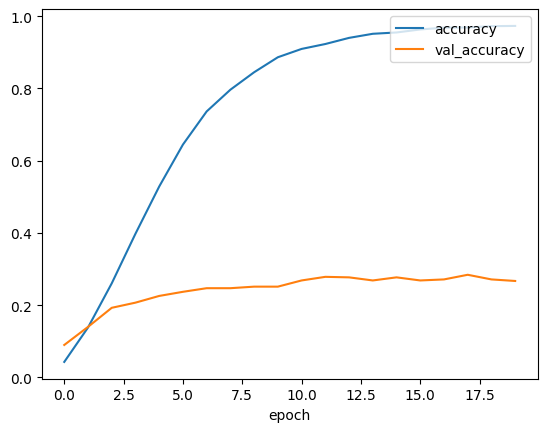

In [22]:
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['accuracy','val_accuracy'],loc='upper right')

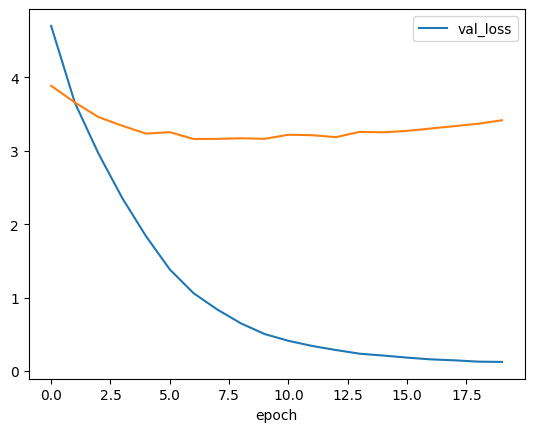

In [24]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['val_loss'],loc='upper right')

In [25]:
#test的照片及label
test_images,test_labels = get_images('/content/dog/test')
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print("shape of test_images",test_images.shape)
print("shape of test_label",test_labels.shape)

shape of test_images (700, 224, 224, 3)
shape of test_label (700,)


In [26]:
model.evaluate(test_images,test_labels)

22/22 [==============================] - 14s 639ms/step - loss: 3.3662 - accuracy: 0.2771


[3.3662140369415283, 0.27714285254478455]

array([[[100, 126, 108],
        [ 72,  98,  80],
        [ 40,  64,  46],
        ...,
        [ 18,  35,  14],
        [ 19,  36,  15],
        [ 20,  37,  16]],

       [[ 98, 124, 106],
        [ 85, 111,  93],
        [ 71,  95,  77],
        ...,
        [ 14,  33,  12],
        [ 12,  31,  12],
        [ 12,  31,  10]],

       [[ 40,  68,  49],
        [ 46,  74,  55],
        [ 56,  82,  64],
        ...,
        [ 18,  38,  19],
        [ 14,  36,  18],
        [ 12,  34,  15]],

       ...,

       [[130, 149, 156],
        [130, 152, 158],
        [132, 153, 161],
        ...,
        [234, 247, 255],
        [234, 247, 255],
        [234, 247, 255]],

       [[130, 151, 159],
        [129, 150, 158],
        [129, 149, 160],
        ...,
        [233, 247, 253],
        [233, 247, 253],
        [233, 247, 253]],

       [[130, 150, 161],
        [128, 148, 159],
        [124, 146, 158],
        ...,
        [232, 246, 252],
        [232, 246, 252],
        [232, 246, 252]]], dtype=uint8)
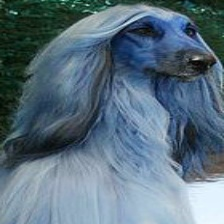

In [28]:
cv2.imread('/content/dog/train/Afghan/002.jpg')

In [58]:
t = cv2.imread('/content/dog/train/Afghan/002.jpg')
t = cv2.resize(t,(224,224))
t = np.array(t)
t = t.reshape(1,t.shape[0],t.shape[1],3)
print(t.shape)
num = np.argmax(model.predict(t),axis=1)
print(num)
print(dog_dict[num[0]])

(1, 224, 224, 3)
1/1 [==============================] - 0s 84ms/step
[25]
Afghan


In [ ]:
#解壓所testing_data
!mkdir testing_set
!unzip Testing_set.zip -d testing_set

In [ ]:
df = pd.DataFrame(columns=["檔名","結果"],index = list(range(len(os.listdir('/content/testing_set/')))))
index = 0
# 把每張照片尺寸轉成224*224，預測完成後存入df
for img in os.listdir('/content/testing_set/'):
  df.iloc[index][0]=img
  temp = cv2.imread(os.path.join('/content/testing_set/',img))
  temp = cv2.resize(temp,(224,224))
  temp = np.array(temp)
  temp = temp.reshape(1,temp.shape[0],temp.shape[1],3)
  df.iloc[index][1]=dog_dict[np.argmax(model.predict(temp),axis=1)[0]]
  index = index + 1

In [86]:
df.to_excel('test_data.xlsx',index=False)